# **Analysis of KMeans (Core)**

Name: Kellianne Yang

# Task

For this task, you will analyze the clusters you made in KMeans Exercise Part 1. 

Your stakeholder is a credit card company that wants to market new credit cards. They have asked you to segment their potential customers to determine how and what kind of cards they should market to each group.

You can download the data here: https://assets.codingdojo.com/boomyeah2015/codingdojo/curriculum/content/chapter/cust_seg.csv

The original data is from this data source: https://github.com/Nikhil-Adithyan/Customer-Segmentation-with-K-Means

1. Make a copy of your code file from KMeans Exercise Part 1.
2. Create analytical visualizations that explore statistics for each feature for each cluster.
3. Write a description of each cluster, based on the visualizations you created. Do more than describe the numbers, try to see past the numbers and describe what kinds of people are represented by each cluster. Include at least one insight for each cluster.
4. Create one or two recommendations for your stakeholders (the credit card company) regarding how they should market credit cards differently, or which cards they should market, to each cluster based on your data and insights.
5. Submit your notebook below.


# Preliminary Steps

In [18]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [19]:
# mount drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [20]:
# load data
path = '/content/drive/MyDrive/Coding Dojo/Stack 3: Advanced Machine Learning (Weeks 9-12)/Week 9: Unsupervised Learning: Clustering/cust_seg.csv'
df = pd.read_csv(path, index_col = 0)

In [21]:
# inspect
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      850 non-null    int64  
 1   Age              850 non-null    int64  
 2   Edu              850 non-null    int64  
 3   Years Employed   850 non-null    int64  
 4   Income           850 non-null    int64  
 5   Card Debt        850 non-null    float64
 6   Other Debt       850 non-null    float64
 7   Defaulted        700 non-null    float64
 8   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 66.4 KB


In [22]:
# inspect
df.sample(10)

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
446,447,36,2,11,49,0.273,0.364,0.0,1.3
453,454,34,1,0,21,0.187,1.325,0.0,7.2
595,596,29,1,3,23,1.104,1.035,NaN,9.3
262,263,32,2,12,54,3.196,4.580,0.0,14.4
130,131,35,1,16,36,0.179,1.045,0.0,3.4
801,802,48,1,30,101,1.875,4.589,0.0,6.4
584,585,38,1,18,44,0.606,1.374,0.0,4.5
18,19,44,1,18,61,2.806,3.782,NaN,10.8
107,108,25,1,8,27,1.019,2.869,0.0,14.4
745,746,45,1,23,50,0.559,1.541,0.0,4.2


In [23]:
# delete column(s) that should not factor into clusters
df.drop(columns = 'Customer Id', inplace = True)

# check
df.columns

Index(['Age', 'Edu', 'Years Employed', 'Income', 'Card Debt', 'Other Debt',
       'Defaulted', 'DebtIncomeRatio'],
      dtype='object')

In [24]:
# check for impossible numeric values
df.describe(include = 'number')

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000,850.000000
mean,35.029412,1.710588,8.565882,46.675294,1.576820,3.078773,0.261429,10.171647
std,8.041432,0.927784,6.777884,38.543054,2.125843,3.398799,0.439727,6.719441
min,20.000000,1.000000,0.000000,13.000000,0.012000,0.046000,0.000000,0.100000
25%,29.000000,1.000000,3.000000,24.000000,0.382500,1.045750,0.000000,5.100000
50%,34.000000,1.000000,7.000000,35.000000,0.885000,2.003000,0.000000,8.700000
75%,41.000000,2.000000,13.000000,55.750000,1.898500,3.903250,1.000000,13.800000
max,56.000000,5.000000,33.000000,446.000000,20.561000,35.197000,1.000000,41.300000


I would like to know more about the units that 'Card Debt', 'Other Debt', and 'Income' are in, but they will be scaled anyway. 

In [25]:
# check for duplicates
df.duplicated().sum()

0

In [26]:
# check for missing values
df.isna().sum()

# will impute values in 'Defaulted' column

Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
DebtIncomeRatio      0
dtype: int64

In [27]:
# preprocess 'Defaulted' column

# instantiate scaler
scaler = StandardScaler()

# instantiate imputer
most_freq_imputer = SimpleImputer(strategy = 'most_frequent', 
                                  add_indicator = True)

# make pipeline
defaulted_pipe = make_pipeline(most_freq_imputer, scaler)

# make tuple
defaulted_tuple = (defaulted_pipe, ['Defaulted'])

In [28]:
# preprocess rest of df

other_cols_df = df.drop(columns = 'Defaulted')
other_cols_list = list(other_cols_df.columns)

# instantiate scaler
scaler = StandardScaler()

# make tuple
other_cols_tuple = (scaler, other_cols_list)

In [29]:
# make preprocessor
preprocessor = make_column_transformer(defaulted_tuple, 
                                       other_cols_tuple, 
                                       remainder = 'drop')

In [30]:
# fit and transform
preprocessed_df = preprocessor.fit_transform(df)

# Elbow plot of inertia

Text(0, 0.5, 'inertia')

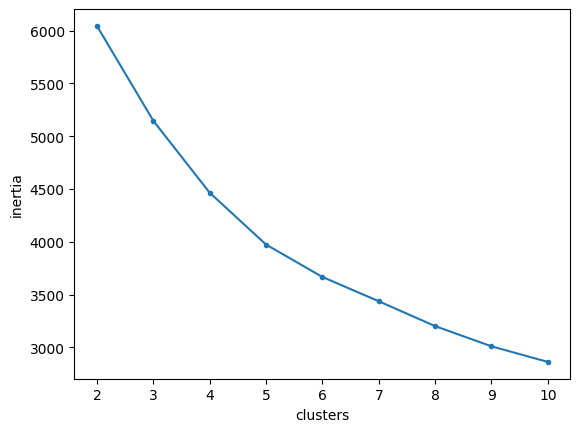

In [31]:
# create list for inertias
inertias = []

# loop through k values 2-10 and store inertias in list
for k in range(2, 11):
  kmeans = KMeans(n_clusters = k, n_init = 10, random_state = 42)
  kmeans.fit(preprocessed_df)
  inertias.append(kmeans.inertia_)

# visualize elbow plot of inertias
plt.plot(range(2,11), inertias, marker = '.')
plt.xlabel('clusters')
plt.ylabel('inertia')

In [32]:
# difficult to discern elbow in plot; compute numerically
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
from kneed import KneeLocator

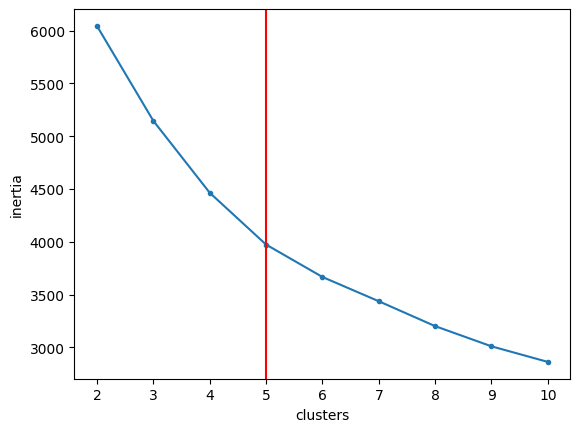

Knee point: 5


In [34]:
# decreasing convex function

# find the knee point using the KneeLocator function
knee_locator = KneeLocator(range(2, 11), 
                           inertias, 
                           curve = 'convex', 
                           direction = 'decreasing',
                           interp_method = 'polynomial')
knee = knee_locator.knee

# plot the data and knee point
plt.plot(range(2, 11), inertias, marker = '.')
plt.axvline(x = knee, color = 'red')
plt.xlabel('clusters')
plt.ylabel('inertia')
plt.xticks(range(2, 11))
plt.show()

print('Knee point:', knee)

# Plot of silhouette scores

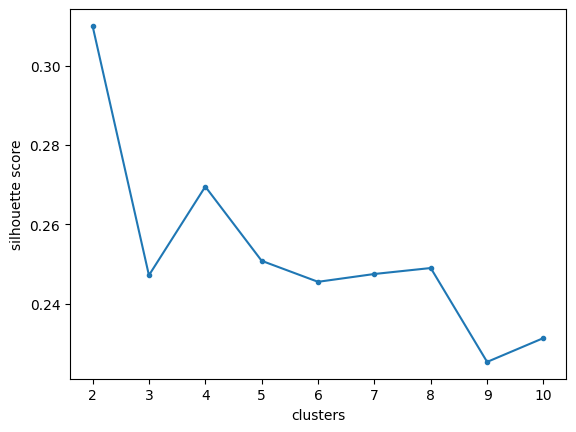

In [35]:
# create list for silhouette scores
silhouette_scores = []

for k in range(2, 11):
  kmeans = KMeans(n_clusters = k, n_init = 10, random_state = 42)
  kmeans.fit(preprocessed_df)
  silhouette_scores.append(silhouette_score(preprocessed_df, kmeans.labels_))

# visualize silhouette_scores
plt.plot(range(2, 11), 
         silhouette_scores, 
         marker = '.')
plt.xlabel('clusters')
plt.ylabel('silhouette score')
plt.xticks(range(2, 11))
# plt.vlines(range(2, 21), 
#            ymin = .18, 
#            ymax = .325, 
#            color = 'red', 
#            linestyle = 'dotted')
plt.show();

In [36]:
# determine how many clusters produces the highest silhouette score in a table
silhouette_df = pd.DataFrame()

silhouette_df['silhouette_score'] = silhouette_scores
silhouette_df['clusters'] = range(2, 11)

silhouette_df.sort_values(by = 'silhouette_score', ascending = False).head()

,silhouette_score,clusters
0,0.309976,2
2,0.269500,4
3,0.250800,5
6,0.248980,8
5,0.247480,7


# K decision

The two plots, an elbow plot and a silhouette score plot, indicate different numbers of clusters to use for this data. The elbow plot indicates 5 clusters, although the elbow plot does not show a very distinct elbow. The silhouette scores indicate that 2 clusters should be used. 

Because the elbow plot does not have a very defined elbow, and the silhouette scores plot clearly indicates that 2 clusters has a much higher silhouette score than the other numbers of clusters, I will choose to continue with 2 clusters. For a more involved analysis, I would look at both 2 and 5 clusters, and maybe a few more similar numbers, as options. 

In [ ]:
# make model with 2 clusters
kmeans = KMeans(n_clusters = 2, n_init = 10, random_state = 42)
kmeans.fit(preprocessed_df)

# add clusters as column in df
df['cluster'] = kmeans.labels_

# check
df.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,cluster
0,41,2,6,19,0.124,1.073,0.0,6.3,0
1,47,1,26,100,4.582,8.218,0.0,12.8,1
2,33,2,10,57,6.111,5.802,1.0,20.9,1
3,29,2,4,19,0.681,0.516,0.0,6.3,0
4,47,1,31,253,9.308,8.908,0.0,7.2,1


# Analytical Visualizations for Each Cluster

Create analytical visualizations that explore statistics for each feature for each cluster.

In [ ]:
# look at aggregate means by cluster in table form
# as_index = False makes clusters a column instead of the index
cluster_groups = df.groupby('cluster', as_index = False).mean()
cluster_groups

,cluster,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,0,32.977545,1.648204,6.479042,33.646707,0.931602,1.907430,0.261261,9.122754
1,1,42.560440,1.939560,16.225275,94.494505,3.944984,7.377989,0.262069,14.021429


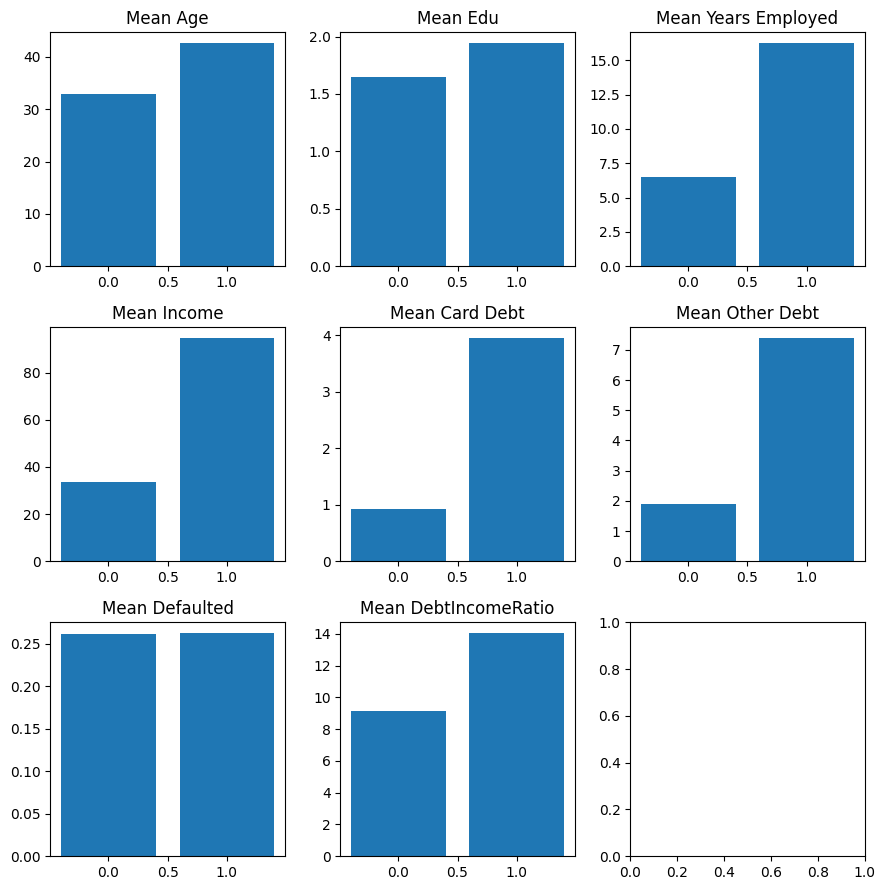

In [ ]:
# visualize the clusters' aggregate means with bar charts
# 8 columns
fig, axes = plt.subplots(3, 3, figsize = (9, 9))

# axes.ravel() flattens array
axes = axes.ravel()

# loop over columns and plot each; skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f"Mean {col}")

plt.tight_layout()

# Descriptions of Each Cluster

Write a description of each cluster, based on the visualizations you created. Do more than describe the numbers, try to see past the numbers and describe what kinds of people are represented by each cluster. Include at least one insight for each cluster.

## Cluster 0:

This cluster is slightly younger (mean age low 30s). They are a little less educated, have been employed for fewer years, and have a lower income, all factors which may relate to their younger age.

They have less card and other debt, and a lower debt to income ratio. They have defaulted at the same rate as cluster 1.

## Cluster 1:

This cluster is older, more educated, has been employed for longer, and has a significantly higher mean income than cluster 0. 

However, they also have much higher card and other debt, and a higher debt to income ratio on average. 

They have defaulted on their debt at about the same rate as cluster 0. 

# Recommendations for Stakeholders

Create one or two recommendations for your stakeholders (the credit card company) regarding how they should market credit cards differently, or which cards they should market, to each cluster based on your data and insights.

Recommendation for Cluster 0: Provide a low-interest, and low-/no-fee credit card option. This cluster makes less money, and also has less debt, and so are probably looking to pay less for a credit card, and pay off what they put on a credit card quickly.

Cluster 1: This cluster is older and earns more money, and accrues more debt. You can provide a higher-interest card option, with a higher limit. They may want a card option with more rewards or points to distinguish from other offers.